In [1]:
# !pip install tensorflow==2.8.0
!pip install efficientnet
!pip install --upgrade wandb
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.9
    Uninstalling wandb-0.15.9:
      Successfully uninstalled wandb-0.15.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 82.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.4 requires botocore<1.31.18,>=1.31.17, but you have botocore 1.29.165 which is incompatible.


In [5]:
import os
import re
import random
import pandas as pd
import numpy as np
import json
import math
import string
import uuid


### Tensorflow Imports
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,confusion_matrix
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Layer, \
                        UpSampling1D, Input, DepthwiseConv2D, Conv2D, \
                        BatchNormalization, ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras.applications import MobileNet


### External models
import efficientnet.tfkeras as efn


### Matplotlib Imports
import matplotlib
import matplotlib.pyplot as plt


### import wandb
import wandb
from wandb.keras import WandbCallback


In [6]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config


def download_files(bucket_name, s3_prefix, local_directory):
    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    bucket = s3.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=s3_prefix):
        local_file = os.path.join(local_directory, obj.key)

        if not os.path.exists(os.path.dirname(local_file)):
            os.makedirs(os.path.dirname(local_file))

        bucket.download_file(obj.key, local_file)
        print(f"Downloaded {obj.key} to {local_file}")

download_files('mitdb128x128', 'train', '/content/input')

Downloaded trainfile_class10_fold0_6117.tfrec to /content/input/trainfile_class10_fold0_6117.tfrec
Downloaded trainfile_class10_fold1_6116.tfrec to /content/input/trainfile_class10_fold1_6116.tfrec
Downloaded trainfile_class10_fold2_6116.tfrec to /content/input/trainfile_class10_fold2_6116.tfrec
Downloaded trainfile_class10_fold3_6116.tfrec to /content/input/trainfile_class10_fold3_6116.tfrec
Downloaded trainfile_class10_fold4_6116.tfrec to /content/input/trainfile_class10_fold4_6116.tfrec
Downloaded trainfile_class10_fold5_6116.tfrec to /content/input/trainfile_class10_fold5_6116.tfrec
Downloaded trainfile_class10_fold6_6116.tfrec to /content/input/trainfile_class10_fold6_6116.tfrec
Downloaded trainfile_class10_fold7_6117.tfrec to /content/input/trainfile_class10_fold7_6117.tfrec
Downloaded trainfile_class10_fold8_6116.tfrec to /content/input/trainfile_class10_fold8_6116.tfrec
Downloaded trainfile_class10_fold9_6116.tfrec to /content/input/trainfile_class10_fold9_6116.tfrec


In [7]:
hparams = {
    "backbone" : "b0",
    "batch_size" : 32,
    "epochs" : 40,
    "img_size" : 128,
    "lr" : 0.01,
    "optimizer" : "adam",
    "seed": 257,
    "notes": "MobileNet-base"
}

In [8]:
class WandBConfigurations():
    def __init__(self, exp_name = "ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS"):
        self.EXPERIMENT_NAME = exp_name
        os.environ["WANDB_API_KEY"] = "221507f411c2ddcc0c17238e115a12c528a482f6"
        wandb.login()

WB = WandBConfigurations()

wandb: Currently logged in as: shreya-srivas02. Use `wandb login --relogin` to force relogin


In [9]:
 class Utils():
    def __init__(self):
        self.seed_everything()

    def id_generator(size=6):
        return str(uuid.uuid4())[:size]

    def setupTPU(self):

        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print('Running on TPU ', tpu.cluster_spec().as_dict())
        except ValueError:
            tpu = None

        if tpu:
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            STRATEGY = strategy
            BATCH_SIZE = 8 * strategy.num_replicas_in_sync
            # wandb.config.hardware = 'TPU'
        else:
            strategy = tf.distribute.get_strategy()
            
        return strategy

    def seed_everything(self):
        np.random.seed(hparams['seed'])
        tf.random.set_seed(hparams['seed'])
        random.seed(a=hparams['seed'])
        os.environ['PYTHONHASHSEED'] = str(hparams['seed'])

UTILS = Utils()
STRATEGY = UTILS.setupTPU()

In [10]:
class Config():
    def __init__(self):
        self.DO_VAL_SPLIT = True
        self.TRAIN_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[:-1]
        self.TOTAL_TRAIN_IMG = 48929
        self.TOTAL_VAL_IMG = 6116
        self.TOTAL_TEST_IMG = 6116
        self.BACKBONE = hparams['backbone']
        self.IMG_TRAIN_SHAPE = [hparams["img_size"],hparams["img_size"]]
        self.DO_FINETUNE = True
        self.BATCH_SIZE = hparams["batch_size"] # 16
        self.EPOCHES = hparams["epochs"]
        self.SEED = hparams["seed"]
        self.LOSS = tf.keras.losses.CategoricalCrossentropy()
        self.OPTIMIZER = self.get_optimizer()
        self.ACCURACY = []
        self.CALLBACKS = []
        self.STRATEGY = STRATEGY
        self.FOLDS = 9
        self.USE_LR_SCHEDULER = True
        self.FOLD_NUMBER = 0
        self.FOLDS_DICT = {}

        if self.USE_LR_SCHEDULER:
            lrfn = self.get_cosine_schedule_with_warmup(lr=hparams['lr'])
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
            self.CALLBACKS.append(lr_schedule)

    def get_optimizer(self):
        if hparams['optimizer'] == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'rmsprop':
            return tf.keras.optimizers.RMSprop(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adagrad':
            return tf.keras.optimizers.Adagrad(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adadelta':
            return tf.keras.optimizers.Adadelta(learning_rate=hparams["lr"])

        return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])

    def get_cosine_schedule_with_warmup(
        self,
        lr = 0.00004,
        num_warmup_steps = 0,
        num_cycles=0.5):
        num_training_steps = self.EPOCHES
        def lrfn(epoch):
            if epoch < num_warmup_steps:
                return (float(epoch) / float(max(5, num_warmup_steps))) * lr
            progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

        return lrfn


CONFIG = Config()

In [11]:
class Data():
    def __init__(self):
        self.LABELED_TFREC_FORMAT = {
            "image_id": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            'target10': tf.io.FixedLenFeature([], tf.int64),
            'gender' : tf.io.FixedLenFeature([], tf.int64),
            'age_interval' : tf.io.FixedLenFeature([], tf.int64),
        }

    def process_training_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10 }

    def process_testing_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)
        image_id = data["image_id"]

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10, "image_id":  data['image_id']}

    def val_dataset(self):
        ignore_order = tf.data.Options()
        val_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(CONFIG.FOLD_NUMBER)]["valfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return val_dataset

    def train_dataset(self):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        train_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(fold_number)]["trainfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).repeat(
            ).shuffle(
                CONFIG.SEED
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return train_dataset

    def test_dataset(self):
        ignore_order = tf.data.Options()
        TEST_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[-1]
        test_dataset = (
            tf.data.TFRecordDataset(
                TEST_FILES,
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_testing_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE *  4
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )
        return test_dataset


In [12]:
def MobileNetAdaptation():
    inp1  = tf.keras.layers.Input(shape = (*CONFIG.IMG_TRAIN_SHAPE, 1), name='inp1')
    inp2  = tf.keras.layers.Input(shape = (2,), name='inp2')
    mm = tf.keras.applications.mobilenet.MobileNet(
            input_shape=(*CONFIG.IMG_TRAIN_SHAPE, 1),
            depth_multiplier=1,
            dropout=0.001,
            include_top=False,
            weights=None,
        )(inp1)

    output = tf.keras.layers.GlobalAveragePooling2D()(mm)
    output10 = tf.keras.layers.Dense(10, activation='softmax', name='target10')(output)

    model = tf.keras.models.Model(inputs = [inp1, inp2], outputs = [output10])

    return model
 

In [13]:
MobileNetAdaptation().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_128 (Functional  (None, 4, 4, 1024)  3228288     ['inp1[0][0]']                   
 )                                                                                                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['mobilenet_1.00_128[0][0]']     
 alAveragePooling2D)                                                                          

In [14]:
def fitengine(model, traindataset, valdataset = None, istraining = True):
    model.compile(
        optimizer   =  CONFIG.OPTIMIZER,
        loss        =  CONFIG.LOSS,
        metrics     =  CONFIG.ACCURACY
    )

    history = model.fit(
                traindataset,
                epochs            =   40,
                steps_per_epoch   =   CONFIG.TOTAL_TRAIN_IMG//CONFIG.BATCH_SIZE,
                callbacks         =   CONFIG.CALLBACKS,
                validation_data   =   valdataset,
                validation_steps = (CONFIG.TOTAL_VAL_IMG)//(CONFIG.BATCH_SIZE) + 1,
                verbose           =   1
            )

    return history

skf = KFold(n_splits=CONFIG.FOLDS,shuffle=True,random_state=CONFIG.SEED)
for fold_number,(idxT,idxV) in enumerate(skf.split(np.arange(len(CONFIG.TRAIN_FILES)))):
    CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)] = {
                                            "trainfiles" : [CONFIG.TRAIN_FILES[x] for x in idxT],
                                            "valfiles"   : [CONFIG.TRAIN_FILES[x] for x in idxV]
                                            }

fold_number = CONFIG.FOLD_NUMBER
print(CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)]['trainfiles'])
print(CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)]['valfiles'])

run_ = wandb.init(
    project= WB.EXPERIMENT_NAME,
    reinit=True,
    dir = "/root",
    allow_val_change = True,
    config = hparams
)

if CONFIG.STRATEGY is not None:
    with CONFIG.STRATEGY.scope():
        x2 = tf.keras.metrics.Precision(name='precision')
        x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
        x4 = tf.keras.metrics.Recall(name='sensitivity')

        CONFIG.ACCURACY.append(x2)
        CONFIG.ACCURACY.append(x3)
        CONFIG.ACCURACY.append(x4)

        model = MobileNetAdaptation()
#         CONFIG.CALLBACKS.append(InLayerLossCallback())
else:
    x2 = tf.keras.metrics.Precision(name='precision')
    x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
    x4 = tf.keras.metrics.Recall(name='sensitivity')
    x4 = tf.keras.metrics.Recall(name='sensitivity')

    CONFIG.ACCURACY.append(x2)
    CONFIG.ACCURACY.append(x3)
    CONFIG.ACCURACY.append(x4)

    model = MobileNetAdaptation()

CONFIG.CALLBACKS.append(tf.keras.callbacks.ModelCheckpoint(
                                'model-%s.h5'%(fold_number), monitor='val_loss', verbose=1, save_best_only=True,
                                save_weights_only=True, mode='min', save_freq='epoch'))

CONFIG.CALLBACKS.append(WandbCallback(save_weights_only=True,
                                            log_weights=True,
                                            log_evaluation=True))




DATA = Data()

print("##"*30)

history = fitengine(model, DATA.train_dataset(), valdataset=DATA.val_dataset()) #training model

print('##'*30)


['/content/input/trainfile_class10_fold0_6117.tfrec', '/content/input/trainfile_class10_fold1_6116.tfrec', '/content/input/trainfile_class10_fold2_6116.tfrec', '/content/input/trainfile_class10_fold4_6116.tfrec', '/content/input/trainfile_class10_fold5_6116.tfrec', '/content/input/trainfile_class10_fold6_6116.tfrec', '/content/input/trainfile_class10_fold7_6117.tfrec', '/content/input/trainfile_class10_fold8_6116.tfrec']
['/content/input/trainfile_class10_fold3_6116.tfrec']


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


############################################################


wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


Epoch 1/40
1529/1529 [==============================] - ETA: 0s - loss: 0.3514 - precision: 0.9194 - accuracy: 0.9814 - sensitivity: 0.8923
Epoch 1: val_loss improved from inf to 1.47519, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 85s 41ms/step - loss: 0.3514 - precision: 0.9194 - accuracy: 0.9814 - sensitivity: 0.8923 - val_loss: 1.4752 - val_precision: 0.7090 - val_accuracy: 0.9402 - val_sensitivity: 0.6825 - lr: 0.0100
Epoch 2/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1978 - precision: 0.9500 - accuracy: 0.9886 - sensitivity: 0.9357
Epoch 2: val_loss improved from 1.47519 to 0.20073, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 61s 40ms/step - loss: 0.1978 - precision: 0.9500 - accuracy: 0.9886 - sensitivity: 0.9357 - val_loss: 0.2007 - val_precision: 0.9506 - val_accuracy: 0.9892 - val_sensitivity: 0.9413 - lr: 0.0100
Epoch 3/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.1694 - precision: 0.9559 - accuracy: 0.9901 - sensitivity: 0.9445
Epoch 3: val_loss did not improve from 0.20073
1529/1529 [==============================] - 47s 31ms/step - loss: 0.1693 - precision: 0.9559 - accuracy: 0.9901 - sensitivity: 0.9445 - val_loss: 2.1167 - val_precision: 0.5640 - val_accuracy: 0.9120 - val_sensitivity: 0.5284 - lr: 0.0099
Epoch 4/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1497 - precision: 0.9619 - accuracy: 0.9914 - sensitivity: 0.9520
Epoch 4: val_loss did not improve from 0.20073
1529/1529 [==============================] - 47s 31ms/step - loss: 0.1497 - precision: 0.9619 - accuracy: 0.9914 - sensitivity: 0.9520 - val_loss:

wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 62s 41ms/step - loss: 0.1229 - precision: 0.9672 - accuracy: 0.9928 - sensitivity: 0.9607 - val_loss: 0.1348 - val_precision: 0.9644 - val_accuracy: 0.9922 - val_sensitivity: 0.9575 - lr: 0.0096
Epoch 7/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1093 - precision: 0.9713 - accuracy: 0.9936 - sensitivity: 0.9647
Epoch 7: val_loss improved from 0.13480 to 0.13333, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 63s 41ms/step - loss: 0.1093 - precision: 0.9713 - accuracy: 0.9936 - sensitivity: 0.9647 - val_loss: 0.1333 - val_precision: 0.9682 - val_accuracy: 0.9933 - val_sensitivity: 0.9645 - lr: 0.0095
Epoch 8/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1019 - precision: 0.9727 - accuracy: 0.9940 - sensitivity: 0.9676
Epoch 8: val_loss did not improve from 0.13333
1529/1529 [==============================] - 49s 32ms/step - loss: 0.1019 - precision: 0.9727 - accuracy: 0.9940 - sensitivity: 0.9676 - val_loss: 0.5758 - val_precision: 0.8663 - val_accuracy: 0.9707 - val_sensitivity: 0.8358 - lr: 0.0093
Epoch 9/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0897 - precision: 0.9758 - accuracy: 0.9948 - sensitivity: 0.9717
Epoch 9: val_loss did not improve from 0.13333
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0897 - precision: 0.9758 - accuracy: 0.9948 - sensitivity: 0.9717 - val_loss:

wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 63s 41ms/step - loss: 0.0861 - precision: 0.9766 - accuracy: 0.9949 - sensitivity: 0.9724 - val_loss: 0.1316 - val_precision: 0.9647 - val_accuracy: 0.9925 - val_sensitivity: 0.9601 - lr: 0.0088
Epoch 11/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0764 - precision: 0.9781 - accuracy: 0.9953 - sensitivity: 0.9747
Epoch 11: val_loss did not improve from 0.13162
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0764 - precision: 0.9781 - accuracy: 0.9953 - sensitivity: 0.9747 - val_loss: 0.1483 - val_precision: 0.9587 - val_accuracy: 0.9913 - val_sensitivity: 0.9537 - lr: 0.0085
Epoch 12/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0694 - precision: 0.9807 - accuracy: 0.9958 - sensitivity: 0.9772
Epoch 12: val_loss improved from 0.13162 to 0.10771, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 63s 41ms/step - loss: 0.0694 - precision: 0.9807 - accuracy: 0.9958 - sensitivity: 0.9772 - val_loss: 0.1077 - val_precision: 0.9725 - val_accuracy: 0.9943 - val_sensitivity: 0.9702 - lr: 0.0082
Epoch 13/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0633 - precision: 0.9821 - accuracy: 0.9962 - sensitivity: 0.9794
Epoch 13: val_loss did not improve from 0.10771
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0633 - precision: 0.9821 - accuracy: 0.9962 - sensitivity: 0.9794 - val_loss: 0.1140 - val_precision: 0.9739 - val_accuracy: 0.9945 - val_sensitivity: 0.9709 - lr: 0.0079
Epoch 14/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0589 - precision: 0.9828 - accuracy: 0.9963 - sensitivity: 0.9804
Epoch 14: val_loss improved from 0.10771 to 0.10644, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 63s 41ms/step - loss: 0.0589 - precision: 0.9828 - accuracy: 0.9963 - sensitivity: 0.9804 - val_loss: 0.1064 - val_precision: 0.9728 - val_accuracy: 0.9944 - val_sensitivity: 0.9707 - lr: 0.0076
Epoch 15/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0544 - precision: 0.9838 - accuracy: 0.9965 - sensitivity: 0.9816
Epoch 15: val_loss did not improve from 0.10644
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0544 - precision: 0.9838 - accuracy: 0.9965 - sensitivity: 0.9816 - val_loss: 0.3181 - val_precision: 0.9179 - val_accuracy: 0.9812 - val_sensitivity: 0.8922 - lr: 0.0073
Epoch 16/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0460 - precision: 0.9860 - accuracy: 0.9970 - sensitivity: 0.9839
Epoch 16: val_loss did not improve from 0.10644
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0460 - precision: 0.9860 - accuracy: 0.9970 - sensitivity: 0.9839 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 64s 42ms/step - loss: 0.0366 - precision: 0.9889 - accuracy: 0.9976 - sensitivity: 0.9874 - val_loss: 0.0992 - val_precision: 0.9777 - val_accuracy: 0.9955 - val_sensitivity: 0.9768 - lr: 0.0062
Epoch 19/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0327 - precision: 0.9901 - accuracy: 0.9979 - sensitivity: 0.9890
Epoch 19: val_loss did not improve from 0.09922
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0327 - precision: 0.9901 - accuracy: 0.9979 - sensitivity: 0.9890 - val_loss: 0.1263 - val_precision: 0.9743 - val_accuracy: 0.9946 - val_sensitivity: 0.9716 - lr: 0.0058
Epoch 20/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0306 - precision: 0.9903 - accuracy: 0.9980 - sensitivity: 0.9892
Epoch 20: val_loss improved from 0.09922 to 0.09889, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231027_100833-rd7alfi4/files/model-best)... Done. 0.2s


1529/1529 [==============================] - 63s 41ms/step - loss: 0.0306 - precision: 0.9903 - accuracy: 0.9980 - sensitivity: 0.9892 - val_loss: 0.0989 - val_precision: 0.9779 - val_accuracy: 0.9955 - val_sensitivity: 0.9768 - lr: 0.0054
Epoch 21/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0244 - precision: 0.9923 - accuracy: 0.9984 - sensitivity: 0.9914
Epoch 21: val_loss did not improve from 0.09889
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0244 - precision: 0.9923 - accuracy: 0.9984 - sensitivity: 0.9914 - val_loss: 0.1102 - val_precision: 0.9776 - val_accuracy: 0.9955 - val_sensitivity: 0.9771 - lr: 0.0050
Epoch 22/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0231 - precision: 0.9927 - accuracy: 0.9985 - sensitivity: 0.9920
Epoch 22: val_loss did not improve from 0.09889
1529/1529 [==============================] - 49s 32ms/step - loss: 0.0231 - precision: 0.9927 - accuracy: 0.9985 - sensitivity: 0.9920 - val_l

In [15]:
model_till_last_epoch = model
SAVED_MODEL_LOC = "model-0.h5"
model = MobileNetAdaptation()
model.load_weights(SAVED_MODEL_LOC)

48/48 [==============================] - 2s 28ms/step
              precision    recall  f1-score   support

           /       1.00      1.00      1.00       382
           A       0.88      0.87      0.87       245
           F       0.89      0.64      0.75        76
           L       0.99      1.00      0.99       801
           N       0.97      0.99      0.98      3252
           R       0.99      0.98      0.99       586
           V       0.96      0.94      0.95       713
           a       0.67      0.55      0.60        11
           f       0.87      0.95      0.91        21
           j       0.73      0.76      0.75        29

    accuracy                           0.97      6116
   macro avg       0.90      0.87      0.88      6116
weighted avg       0.97      0.97      0.97      6116

48/48 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           /       1.00      0.99      1.00       382
           A       0.90 

accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
precision,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████
sensitivity,▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_accuracy,▄▇▁▁▆██▆▆█████▇█████████████████████████
val_loss,▅▁▇█▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▄▇▁▁▇██▆▇█████▇█████████████████████████
val_sensitivity,▃▇▁▁▆██▆▆█████▇█████████████████████████
accuracy,1.0


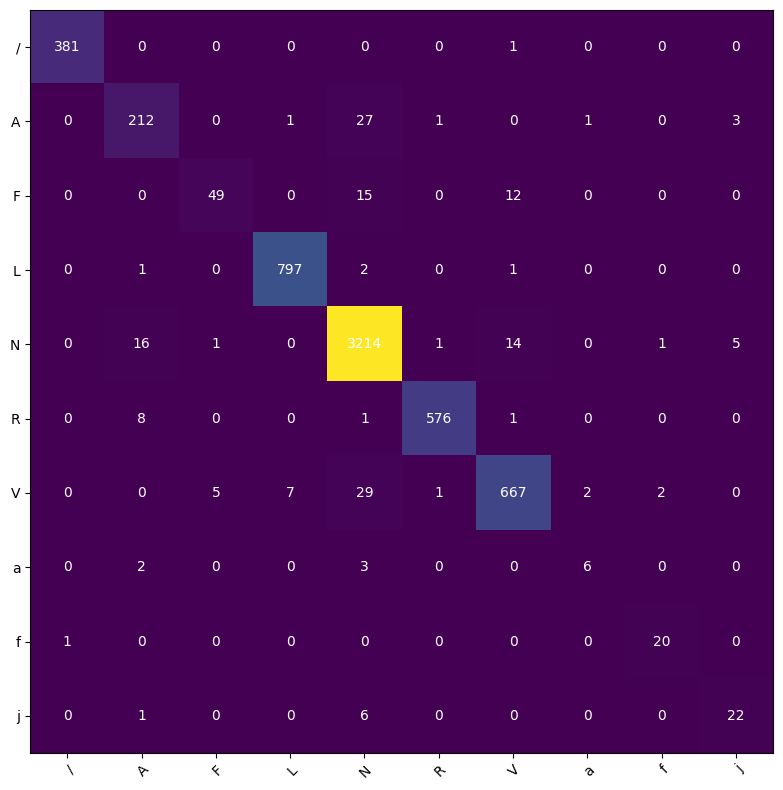

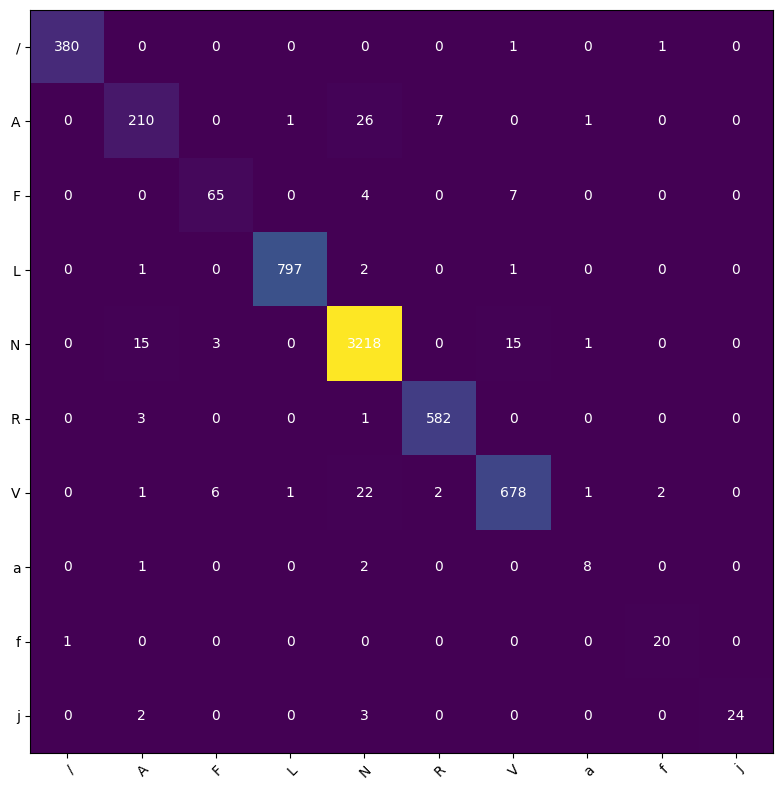

In [16]:
NAME = ['/', "A",  'F', 'L', 'N', 'R', 'V', 'a', 'f', 'j']
for model_type, trained_model in zip(['best_epoch', 'last_epoch'], [model, model_till_last_epoch]):
    test_imgs = DATA.test_dataset().map(lambda data, ids: data)
    img_labels_ds = DATA.test_dataset().map(lambda data, ids: ids).unbatch()

    STEPS = (CONFIG.TOTAL_TEST_IMG)//(CONFIG.BATCH_SIZE*4) + 1

    y_pred = trained_model.predict(test_imgs,steps = int(STEPS), verbose=1)
    test_labels = next(iter(img_labels_ds.batch(int(CONFIG.TOTAL_TEST_IMG) + 1)))
    y_true = test_labels["target10"].numpy()
    pd.DataFrame({
            'image_id'  : test_labels["image_id"].numpy(),
            'actual'  : np.argmax(y_true, axis=1),
            'predicted'      : np.argmax(y_pred, axis=1)
            }).to_csv('prediction_{}.csv'.format(model_type), index=False)

    df = pd.read_csv("prediction_{}.csv".format(model_type))

    run_.log({f"{model_type}_pr": wandb.plot.pr_curve(np.argmax(y_true, axis=1), y_pred, labels=NAME)})
    run_.log({f"{model_type}_roc": wandb.plot.roc_curve(np.argmax(y_true, axis=1), y_pred, labels=NAME)})

    cm = wandb.plot.confusion_matrix(
                    y_true=np.argmax(y_true, axis=1),
                    preds=np.argmax(y_pred, axis=1),
                    class_names=NAME)

    run_.log({f"{model_type}_conf_mat": cm})

    harvest = confusion_matrix(df['actual'], df['predicted'])
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(harvest)
    ax.set_xticks(np.arange(len(NAME)))
    ax.set_yticks(np.arange(len(NAME)))
    ax.set_xticklabels(NAME)
    ax.set_yticklabels(NAME)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    for i in range(len(NAME)):
        for j in range(len(NAME)):
            text = ax.text(j, i, harvest[i, j],
                        ha="center", va="center", color="w")

    fig.tight_layout()

    from sklearn.metrics import classification_report
    target_names = NAME
    x_ = classification_report(df['actual'], df['predicted'], target_names=target_names)
    print(x_)


## log more
run_.finish()